# Dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="gaB102fGQBWerkKpQYJg")
project = rf.workspace("outsource-lvhq6").project("osteoporosis-dmnqk")
version = project.version(1)
dataset = version.download("yolov8")
                

# Model and traning

In [2]:
from ultralytics import YOLO

# Load model
model = YOLO("yolov8n.yaml")

# Train
# model.train(
#     data="osteoporosis.v1i.yolov8/data.yaml",  # đường dẫn đến file data.yaml của Roboflow export
#     epochs=100,
#     imgsz=640,
#     batch=16,
#     name="roi_yolov8n",
#     pretrained=True  # nếu dùng yolov8n.pt
# )

# Test

In [2]:
from ultralytics import YOLO
import cv2
import os

def detect_and_crop_roi(image_path, output_dir="crop", model=None, conf_threshold=0.3):
    # import os
    # os.makedirs(output_dir, exist_ok=True)

    # Load ảnh gốc
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path)

    # Run inference
    results = model(image_path, conf=conf_threshold)[0]

    # Duyệt từng bounding box
    for i, box in enumerate(results.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cropped = image[y1:y2, x1:x2]
        cropped = cv2.resize(cropped, (224, 224))

        # Lưu ảnh crop
        crop_name = f"{os.path.splitext(image_name)[0]}_roi{i+1}.png"
        crop_path = os.path.join(output_dir, crop_name)
        cv2.imwrite(crop_path, cropped)
        print(f"Cropped ROI saved to: {crop_path}")


In [3]:
# Load model đã huấn luyện xong
model = YOLO("runs/detect/roi_yolov8n/weights/best.pt")
# detect_and_crop_roi("Data/osteoporosis/31.JPEG", model=model)


# Apply

In [ ]:
import os
input_dir = "data/Data_x3"
output_dir = "data/Data_x3_ROI"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f"{output_dir}/normal", exist_ok=True)
os.makedirs(f"{output_dir}/osteoporosis", exist_ok=True)
out_map = {
    "normal": "normal",
    "osteoporosis": "osteoporosis",
    # "osteopenia": "osteoporosis"
}
cnt = 0
for label in os.listdir(input_dir):
    if label in out_map.keys():
        files = os.listdir(f"{input_dir}/{label}")
        for file in files:
            cnt += 1
            detect_and_crop_roi(image_path=f"{input_dir}/{label}/{file}", output_dir=f"{output_dir}/{out_map[label]}", model=model)



image 1/1 /home/bbsw/osteoporosis/Data_x3/normal/Normal 401_aug3.png: 640x288 1 roi, 19.6ms
Speed: 3.3ms preprocess, 19.6ms inference, 61.7ms postprocess per image at shape (1, 3, 640, 288)
Cropped ROI saved to: Data_x3_ROI/normal/Normal 401_aug3_roi1.png

image 1/1 /home/bbsw/osteoporosis/Data_x3/normal/Normal 10_aug3.png: 640x288 1 roi, 2.6ms
Speed: 0.8ms preprocess, 2.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 288)
Cropped ROI saved to: Data_x3_ROI/normal/Normal 10_aug3_roi1.png

image 1/1 /home/bbsw/osteoporosis/Data_x3/normal/Normal 442_aug3.png: 640x320 1 roi, 19.1ms
Speed: 0.6ms preprocess, 19.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)
Cropped ROI saved to: Data_x3_ROI/normal/Normal 442_aug3_roi1.png

image 1/1 /home/bbsw/osteoporosis/Data_x3/normal/Normal 19_orig.png: 640x288 1 roi, 2.2ms
Speed: 0.7ms preprocess, 2.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 288)
Cropped ROI saved to: Data_x3_ROI/normal/Normal 

In [ ]:
normal_files = os.listdir('data/Data_ROI/normal')
ost_files = os.listdir('data/Data_ROI/osteoporosis')

len(normal_files), len(ost_files)

(1001, 1216)


0: 640x256 1 roi, 2.1ms
Speed: 21.1ms preprocess, 2.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 256)


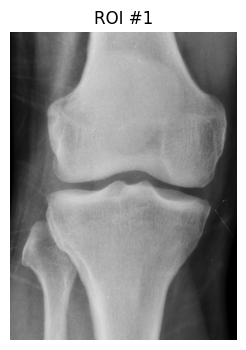

In [23]:
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_roi(image, model=None, conf_threshold=0.3):
    results = model(image, conf=conf_threshold)[0]
    roi = []
    height, width = image.shape[:2]

    for i, box in enumerate(results.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        # Mở rộng chiều dọc thêm 10% chiều cao của box
        box_height = y2 - y1
        pad = int(box_height * 0.1)
        y1_new = max(y1 - pad, 0)
        y2_new = min(y2 + pad, height)
        cropped = image[y1_new:y2_new, x1:x2]
        
        roi.append(cropped)
        if len(roi) == 2:
            break

    return roi


image = cv2.imread("data/Data_x3/normal/2_orig.png")
roi_image = detect_and_crop_roi(image, model, conf_threshold=0.3)

# Hiển thị ảnh đã cắt
for idx, r in enumerate(roi_image):
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(r, cv2.COLOR_BGR2RGB))
    plt.title(f'ROI #{idx+1}')
    plt.axis('off')
    plt.show()

In [ ]:
def roi_extract(image, model, conf_threshold=0.3, max_rois=2):
    # Run inference
    results = model(image, conf=conf_threshold)[0]
    boxes = results.boxes
    height, width = image.shape[:2]
    
    # Clone ảnh gốc để vẽ
    image_with_boxes = image.copy()
    rois = []

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cropped = image[y1:y2, x1:x2]
        rois.append(cropped)

        # Vẽ bounding box
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

        if len(rois) >= max_rois:
            break

    return image_with_boxes, rois

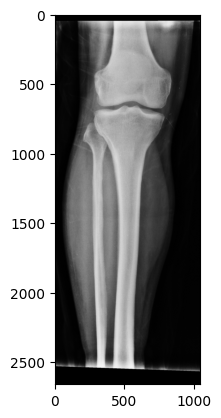

In [17]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("data/Data_x3/normal/2_orig.png")
plt.imshow(image)
plt.show()

In [27]:
image_with_boxes, rois = roi_extract(image, model, conf_threshold=0.3, max_rois=2)


0: 640x256 1 roi, 2.1ms
Speed: 7.8ms preprocess, 2.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 256)


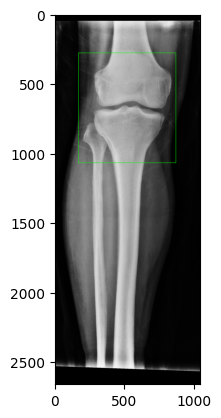

In [28]:
plt.imshow(image_with_boxes)
plt.show()

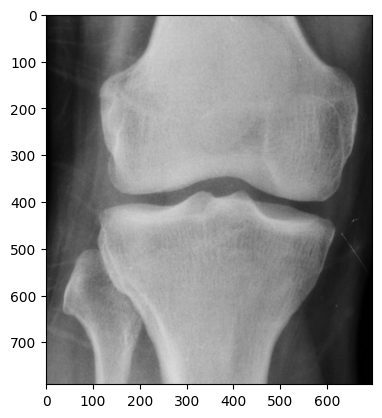

In [29]:
plt.imshow(rois[0])
plt.show()